In [1]:
# Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной

In [2]:
# загрузка пакетов
import numpy as np
import random

In [3]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10)
# всего наблюдений, доля обучающей выборки
n_all, train_percent = 50, 0.85
# параметры распределения X
x_min, x_max = 5, 105
# генерируем X
x = np.random.uniform(x_min, x_max, n_all)
# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)
# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all),
 int(n_all*train_percent), replace=False)
# истинная функция взаимосвязи
def y_func (x) :
 return(6 + 3.5 * np.sin((x - 30)/12))

# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)
# фактические значения y (с шумом)
y = y_func(x) + res
# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]
# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

In [4]:
# загрузка пакетов
import matplotlib.pyplot as plt

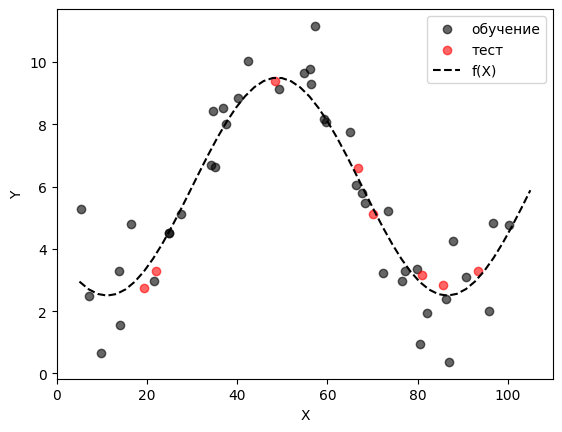

In [5]:
# график 1: исходные данные
# обучающая выборка
plt.scatter(x_train, y_train, c='black', label='обучение', alpha=0.6)
# тестовая выборка
plt.scatter(x_test, y_test, c='red', label='тест', alpha=0.6)
# истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend()
plt.show()

In [6]:
# Обучаем модели и оцениваем их точность

In [7]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

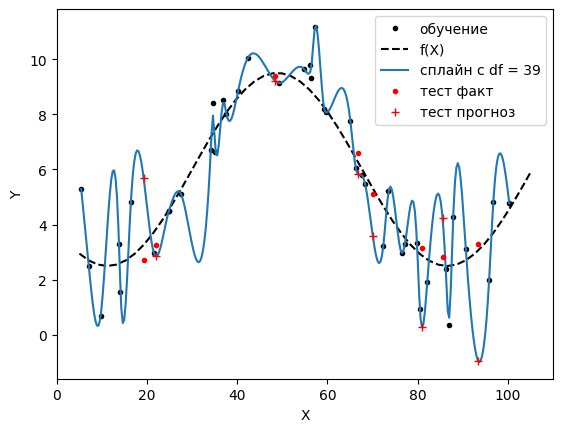

In [8]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 39
# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300,
 endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit,
 robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit,
 robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit,
 robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.',
 label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
 label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='',
 label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.',
 label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+',
 label='тест прогноз')
# подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
 sum((y_test - y_hat_test)**2) / len(y_test)]

In [9]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.02, 5.01])

In [10]:
# Теперь строим модели с df от 2 до 40 #################################
###
# максимальное число степеней свободы для модели сплайна
max_df = 40
# фрейм данных для сохранения MSE на обучающей и на тестовой
# при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
 index=list(range(2, max_df+1)))
# заполняем фрейм
for i_df in range(2, max_df+1) :

 # обучаем модель
 fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)

 # прогноз на обучающей выборке
 y_train_hat = np.array(robjects.r['predict'](fit,
 robjects.FloatVector(x_train)).rx2('y'))
 # прогноз на тестовой выборке
 y_test_hat = np.array(robjects.r['predict'](fit,
 robjects.FloatVector(x_test)).rx2('y'))

 # считаем MSE
 MSE_all_dfs.loc[i_df, 'MSE_train'] = \
 sum((y_train - y_train_hat)**2) / len(y_train_hat)
 MSE_all_dfs.loc[i_df, 'MSE_test'] = \
 sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [11]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
7,1.01922,0.266175


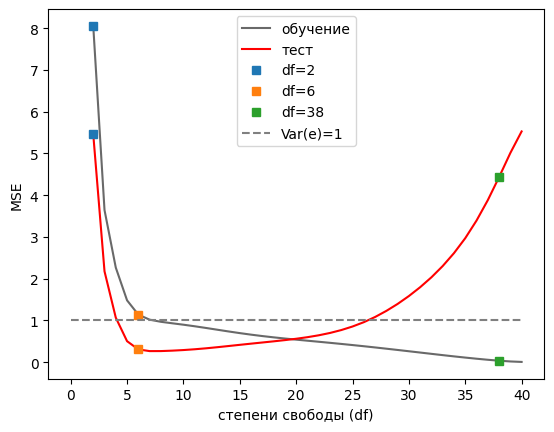

In [12]:
 # график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
 marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
 marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
 MSE_all_dfs.iloc[0]['MSE_test']],
 ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
 MSE_all_dfs.iloc[4]['MSE_test']],
 ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
 MSE_all_dfs.iloc[36]['MSE_test']],
 ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
# подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')
plt.show()